In [1]:
basepath='/blue/adamginsburg/adamginsburg/jwst/brick'

In [2]:
cd $basepath

/blue/adamginsburg/adamginsburg/jwst/brick


In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry


/scratch/local/5800391/ipykernel_61054/3909488129.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/5800391/ipykernel_61054/3909488129.py:1: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/scratch/local/5800391/ipykernel_61054/3909488129.py:1: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_peaks` to 

In [6]:
import warnings

In [17]:
import sys
if '' in sys.path:
    sys.path.remove('')
import regions
import importlib as imp
imp.reload(regions)
regions

<module 'regions' from '/blue/adamginsburg/adamginsburg/repos/regions/regions/__init__.py'>

In [18]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [19]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [20]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [21]:
import glob
from astropy.io import fits

In [22]:
%run $basepath/analysis/analysis_setup.py

/orange/adamginsburg/jwst/brick/analysis/analysis_setup.py:19: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/orange/adamginsburg/jwst/brick/analysis/analysis_setup.py:19: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/orange/adamginsburg/jwst/brick/analysis/analysis_setup.py:19: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection i

For module nrca catalog crowdsource_nsky0_nrca_photometry_tables_merged.fits, mod date is 2023-08-29 03:01:42
For module nrcb catalog crowdsource_nsky0_nrcb_photometry_tables_merged.fits, mod date is 2023-08-29 06:35:22
For module merged catalog crowdsource_nsky0_merged_photometry_tables_merged.fits, mod date is 2023-08-28 23:41:53
For module merged-reproject catalog crowdsource_nsky0_merged-reproject_photometry_tables_merged.fits, mod date is 2023-08-28 18:17:01


In [26]:
%run $basepath/analysis/selections.py --module=merged-reproject

/orange/adamginsburg/jwst/brick/analysis/selections.py:17: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/orange/adamginsburg/jwst/brick/analysis/selections.py:17: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
/orange/adamginsburg/jwst/brick/analysis/selections.py:17: DeprecationWarning: `photutils.find_peaks` is a deprecated alias for `photutils.detection.find_peaks` and will be removed in the future. Instead, please use `from photutils.detection import find_p

Selecting module merged-reproject

NRCA
612 saturated in near_saturated_f212n_f212n
26 saturated in near_saturated_f466n_f466n
58 saturated in near_saturated_f405n_f405n
278 saturated in near_saturated_f187n_f187n
2757 saturated in near_saturated_f182m_f182m
4122 near saturated out of 295443.  That leaves 291321 not near unsaturated
70 saturated in replaced_saturated_f212n
10 saturated in replaced_saturated_f466n
30 saturated in replaced_saturated_f405n
19 saturated in replaced_saturated_f187n
117 saturated in replaced_saturated_f182m
311 saturated out of 295443.  That leaves 295132 unsaturated
Filter f410m has qf=90240, spread=90840, fracflux=64273 ok, totaling 63753.  There are 295443 total, of which 209658 are masked and 85785 are unmasked. qfmasksum=203641, inverse=91802.
Filter f212n has qf=171989, spread=173434, fracflux=128156 ok, totaling 127867.  There are 295443 total, of which 125512 are masked and 169931 are unmasked. qfmasksum=121032, inverse=174411.
Filter f466n has qf=64

In [24]:
blue_BrA_and_PaA.sum()

9669

In [27]:
recomb_excess_over_212.sum()

5016

In [25]:
(blue_BrA_and_PaA & (basetable['mag_ab_f405n'] > 15)).sum()

7800

In [28]:
blue_BrA_and_PaA[all_good].sum()

9248

In [29]:
(blue_BrA_and_PaA & recomb_excess_over_212).sum()

665

In [30]:
(blue_BrA_and_PaA & recomb_excess_over_212)[all_good].sum()

594

In [31]:
blue_405_410.sum()

745

In [32]:
blue_405_410b.sum()

2950

In [33]:
basetable[blue_BrA_and_PaA][:2]

skycoord_ref,skycoord_ref_filtername,sep_f410m,id_f410m,skycoord_f410m,x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,mask_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,mask_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,mask_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,mask_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,mask_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,mask_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182,good_f410m,good_f212n,good_f466n,good_f405n,good_f187n,good_f182m
"deg,deg",,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,Jy,,Jy,,Jy,,Jy,,,,,,,
SkyCoord,bytes5,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,f

Text(0.5, 0, 'F410M S/N ratio')

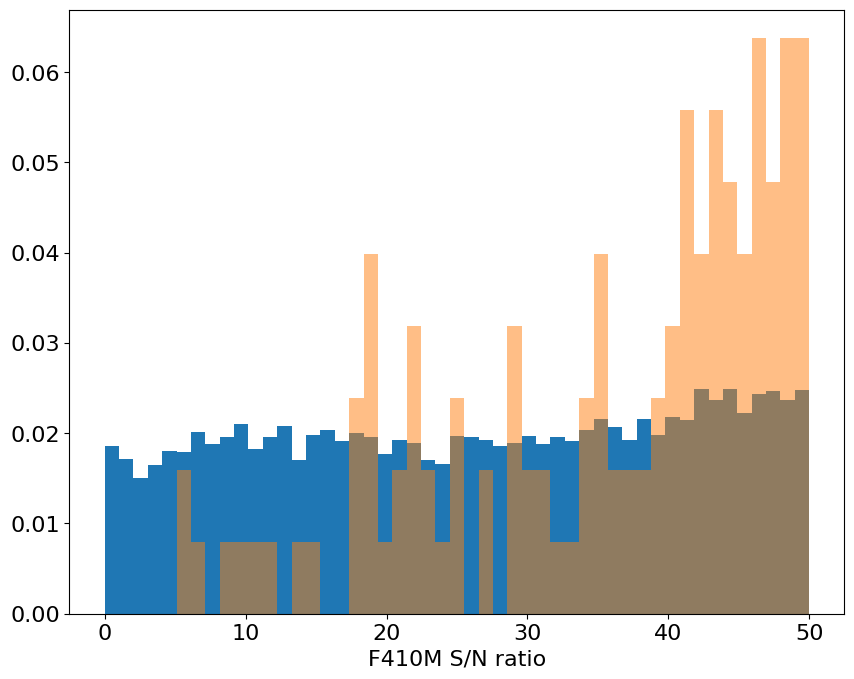

In [35]:
pl.hist(basetable['flux_f410m'] / basetable['dflux_f410m'], density=True, bins=np.linspace(0,50))
pl.hist((basetable['flux_f410m'] / basetable['dflux_f410m'])[blue_BrA_and_PaA], density=True, bins=np.linspace(0,50), alpha=0.5);
pl.xlabel("F410M S/N ratio");

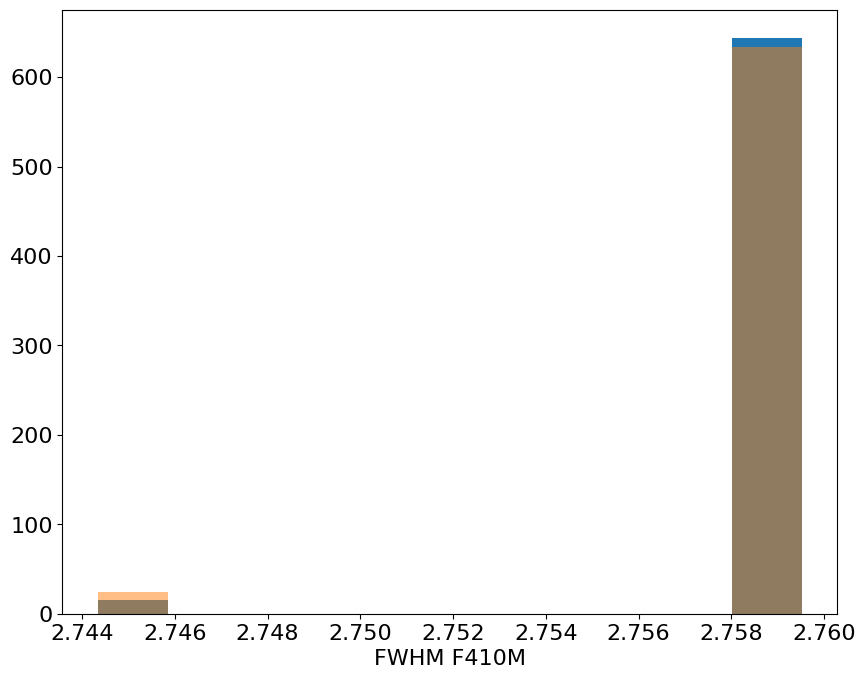

In [37]:
pl.hist(basetable['fwhm_f410m'], density=True)
pl.hist(basetable['fwhm_f410m'][blue_BrA_and_PaA], density=True, alpha=0.5)
pl.xlabel("FWHM F410M");

Text(0.5, 0, 'Reduced chi^2 F410M')

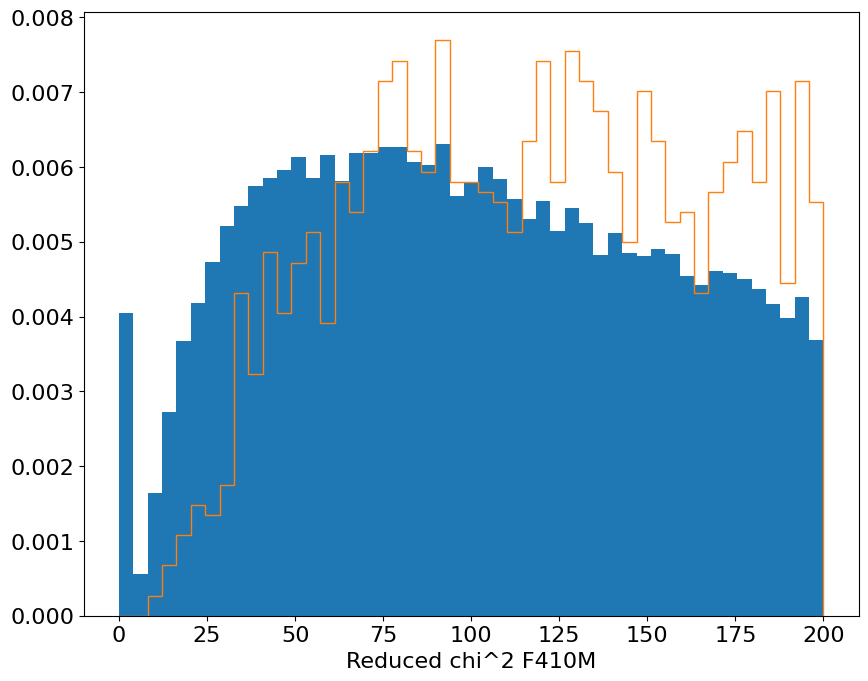

In [38]:
pl.hist(basetable['rchi2_f410m'], density=True, bins=np.linspace(0,200))
h,l,p = pl.hist(basetable['rchi2_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0,200), histtype='step');
pl.xlabel("Reduced chi^2 F410M");

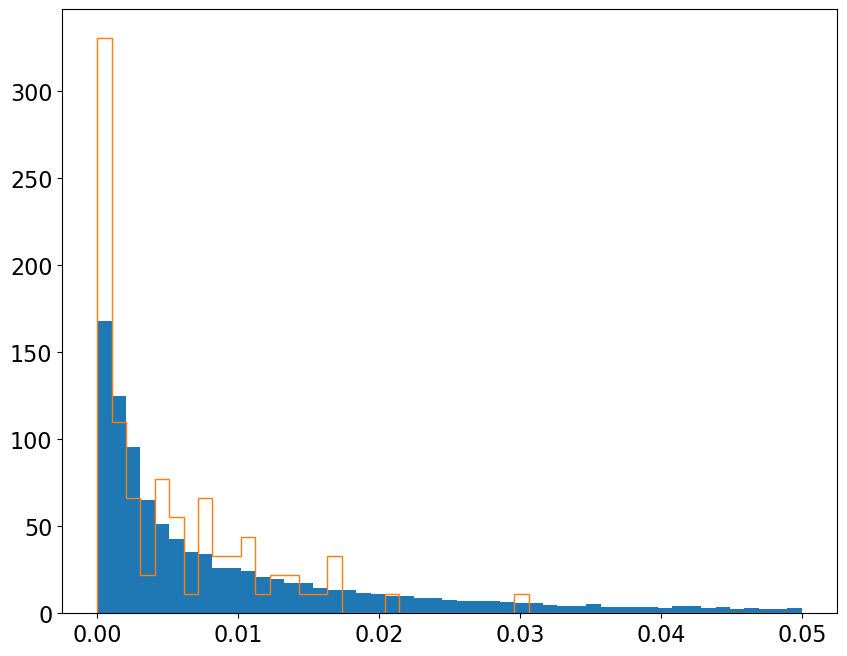

In [22]:
pl.hist(basetable['spread_model_f410m'], density=True, bins=np.linspace(0,0.05))
h,l,p = pl.hist(basetable['spread_model_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0,.05), histtype='step');

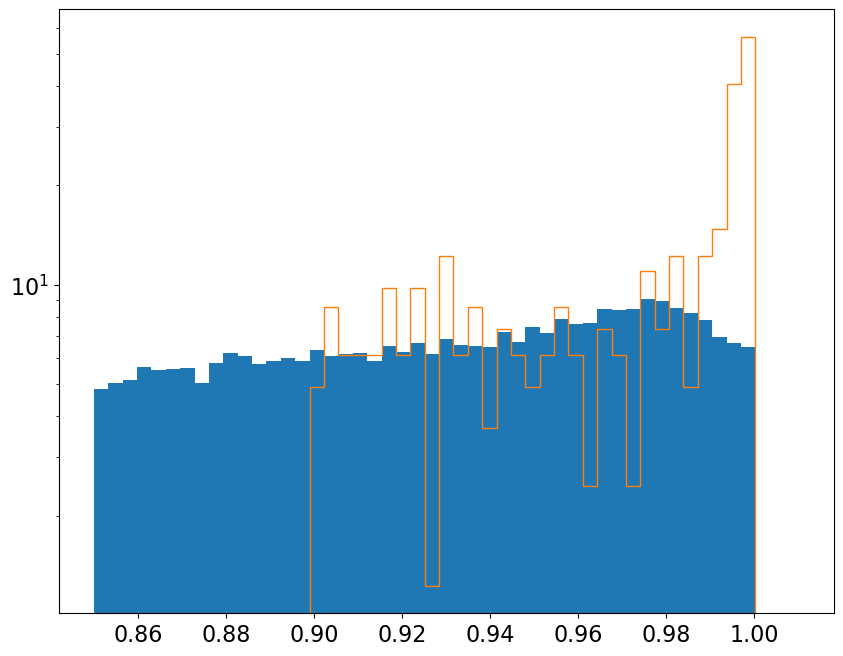

In [23]:
pl.hist(basetable['qf_f410m'], density=True, bins=np.linspace(0.85, 1.01), log=True)
pl.hist(basetable['qf_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0.85, 1.01), histtype='step', log=True);

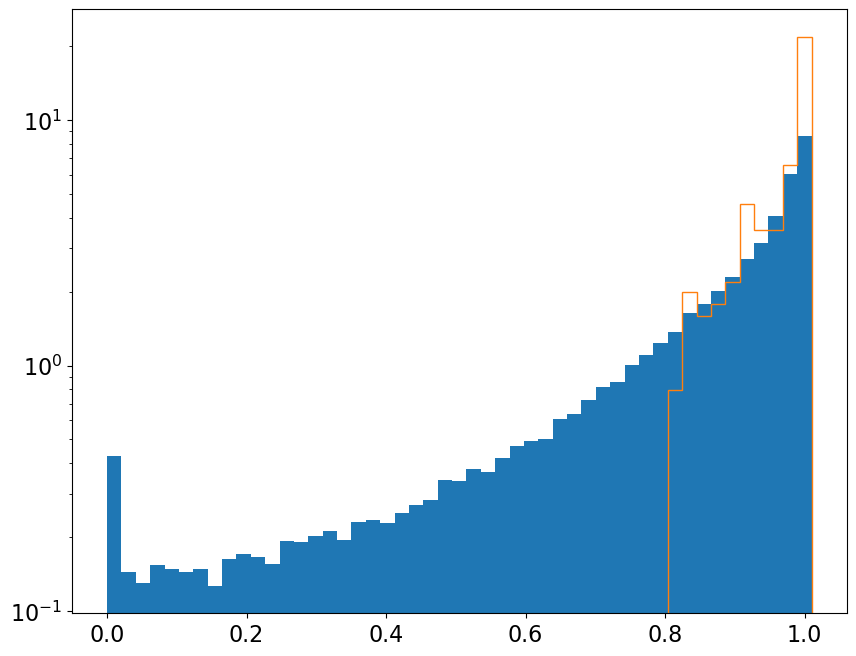

In [24]:
pl.hist(basetable['fracflux_f410m'], density=True, bins=np.linspace(0., 1.01), log=True)
pl.hist(basetable['fracflux_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0., 1.01), histtype='step', log=True);

In [25]:
basetable[blue_BrA_and_PaA].write(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged_BlueBrAandPaA.fits', overwrite=True)

In [26]:
basetable[blue_BrA_and_PaA][:5]

skycoord_ref,sep_f410m,id_f410m,skycoord_f410m,x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,mask_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,mask_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,mask_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,mask_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,mask_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,mask_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182,good_f410m,good_f212n,good_f466n,good_f405n,good_f187n,good_f182m
"deg,deg",deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,Jy,,Jy,,Jy,,Jy,,,,,,,
SkyCoord,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,f

In [27]:
basetable[blue_BrA_and_PaA]['skycoord_f410m'][0]

<SkyCoord (ICRS): (ra, dec) in deg
    (266.51299602, -28.74009131)>

In [125]:
import plot_tools
import importlib as imp
imp.reload(plot_tools)
import plot_tools

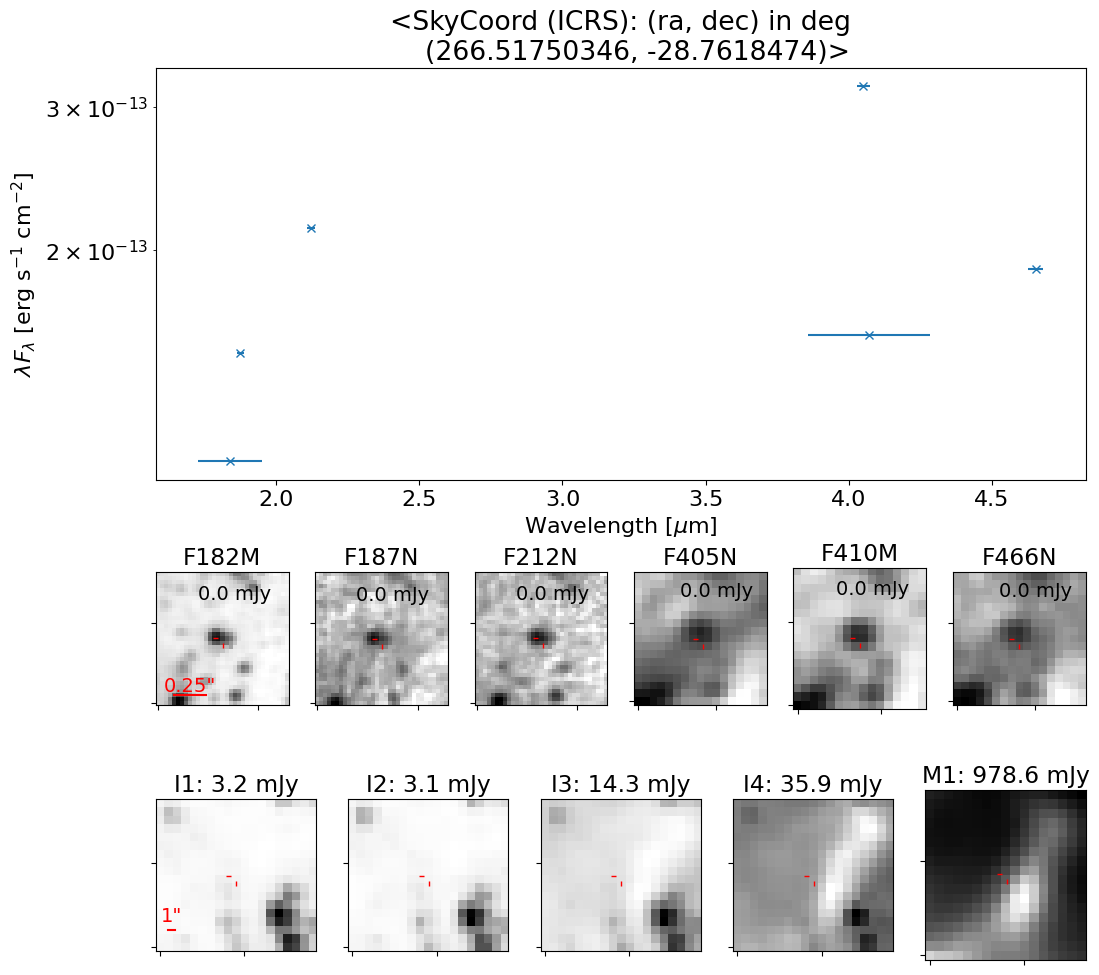

In [126]:
sel = blue_BrA_and_PaA & recomb_excess_over_212 & all_good
plot_tools.sed_and_starzoom_plot(basetable[sel]['skycoord_f410m'][0], basetable=basetable[sel][0:1], idx=0, module='merged-reproject');

In [127]:
crd = basetable[blue_BrA_and_PaA]['skycoord_f410m'][0].galactic
f'JWST2221_G{crd.l.value:0.4f}{crd.b.value:+0.4f}'

'JWST2221_G0.2002+0.0053'

# loop through all candidates

In [128]:
mkdir sed_plots

mkdir: cannot create directory ‘sed_plots’: File exists


In [129]:
from astropy import log

In [130]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)

<module 'plot_tools' from '/orange/adamginsburg/jwst/brick//analysis/plot_tools.py'>

In [131]:
from tqdm.auto import tqdm

594


0it [00:00, ?it/s]

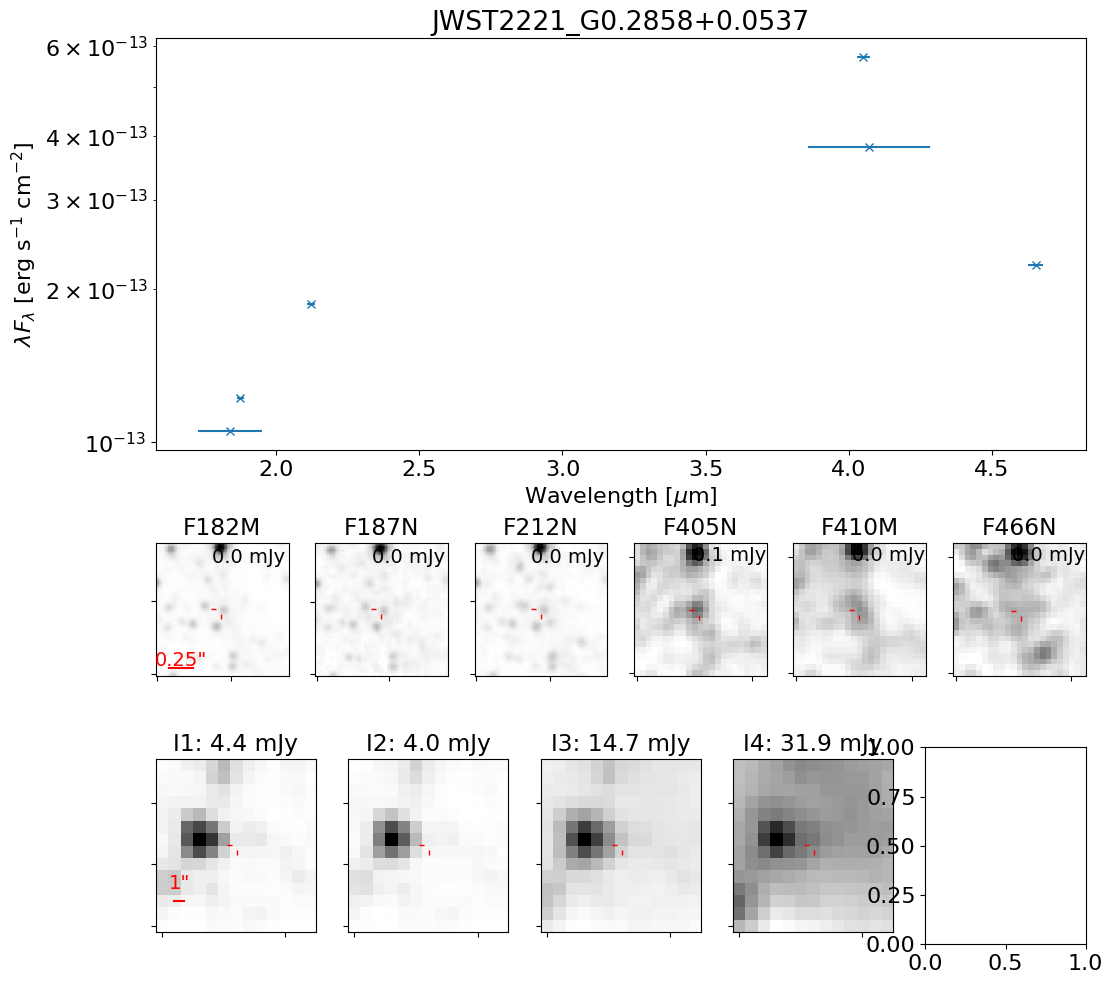

In [132]:
sel = blue_BrA_and_PaA & recomb_excess_over_212 & all_good
print(sel.sum())
for ii, crd in tqdm(enumerate(basetable[sel]['skycoord_f410m'])):
    #print(crd, crd.galactic)
    crd = crd.galactic
    with log.log_to_file('/dev/null'):
        name = f'JWST2221_G{crd.l.value:0.4f}{crd.b.value:+0.4f}'
        fig, _ = plot_tools.sed_and_starzoom_plot(crd, basetable=basetable[sel], title=name, idx=ii)
        fig.savefig(f'{basepath}/sed_plots/{name}_SED.png', bbox_inches='tight')

### play with offset crosshair marker making

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# Define the target location where the lines intersect
tx, ty = np.random.randn(1), np.random.randn(1)



offset_crosshair = Path([
    (-1, 0),
    (-2, 0),
    (0, -1),
    (0, -2),
],
     codes=(1,2,1,2),
)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the custom marker at the target location
marker = patches.PathPatch(marker_path, facecolor='none', lw=2, edgecolor='red')
#ax.add_patch(marker)
ax.plot(tx, ty, 'r', marker=offset_crosshair, markersize=50, markerfacecolor='none')  # Plot the target location

# Set the axis limits
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)

# Show the plot
plt.show()
